# Long Short Term Memory On Reber Grammar

This notebook is using a long-short term memory architecture to solve Reber Grammar, and to see whether a LSTM system can train to generate a string that follows the rule, specifically the rule that requires the 2nd and 2nd to last characters to be the same.

In [2]:
import random
import torch
import torch.nn as nn
import time
import torch.nn.utils.rnn as rnn_utils
from torch.utils.data import DataLoader

Here, the graphs and one-hot-encoding structures are hard-defined to be used later. The graph, pictured below, is implemented with the Graph structure. The nodepositions are the paths, and the pairings/inverse pairings are lookup dictionaries. 

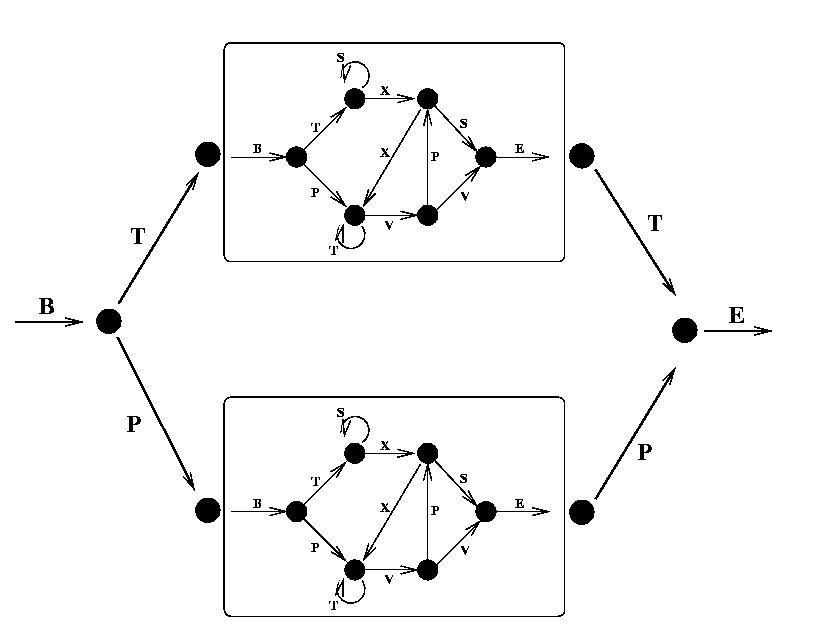

In [3]:
graph = {
    1: [2],
    2: [3, 4],
    3: [3, 6],
    4: [4, 5],
    5: [3, 7],
    6: [7],
    7: [8]
}

node_positions= {
    (1, 2) :'B',
    (2, 3):'P',
    (3, 3): 'T',
    (3, 6): 'V',
    (2, 4): 'T',
    (4, 4): 'S',
    (4, 5): 'X',
    (5, 3): 'X',
    (6, 5): 'P',
    (5, 7):'S',
    (6, 7): 'V',
    (7, 8): 'E'
}

valid_starts = ['T', 'P']

pairings = {
    'B':(1,0,0,0,0,0,0),
    'T':(0,1,0,0,0,0,0),
    'P':(0,0,1,0,0,0,0),
    'S':(0,0,0,1,0,0,0),
    'X':(0,0,0,0,1,0,0),
    'V':(0,0,0,0,0,1,0),
    'E':(0,0,0,0,0,0,1)
}

inverse_pairings = {
    (1,0,0,0,0,0,0):'B',
    (0,1,0,0,0,0,0):'T',
    (0,0,1,0,0,0,0):'P',
    (0,0,0,1,0,0,0):'S',
    (0,0,0,0,1,0,0):'X',
    (0,0,0,0,0,1,0):'V',
    (0,0,0,0,0,0,1):'E'
}

disallowed_pairings = {
    'B': ('B', 'S', 'X', 'V', 'E'),
    'T': ('B', 'P', 'X', 'E'),
    'P': ('B', 'P', 'V', 'E'),
    'S': ('B', 'T', 'P', 'V'),
    'X': ('B', 'P', 'V', 'E'),
    'V': ('B', 'T', 'S', 'X'),
    'E':('B', 'T', 'P', 'S', 'X', 'V', 'E')
}   

In [3]:
graph = {
    1: [2],
    2: [3, 4],
    3: [3, 6],
    4: [4, 5],
    5: [3, 7],
    6: [7],
    7: [8]
}

node_positions= {
    (1, 2) :'B',
    (2, 3):'P',
    (3, 3): 'T',
    (3, 6): 'V',
    (2, 4): 'T',
    (4, 4): 'S',
    (4, 5): 'X',
    (5, 3): 'X',
    (6, 5): 'P',
    (5, 7):'S',
    (6, 7): 'V',
    (7, 8): 'E'
}

valid_starts = ['T', 'P']

pairings = {
    'B':(1,0,0,0,0,0,0),
    'T':(0,1,0,0,0,0,0),
    'P':(0,0,1,0,0,0,0),
    'S':(0,0,0,1,0,0,0),
    'X':(0,0,0,0,1,0,0),
    'V':(0,0,0,0,0,1,0),
    'E':(0,0,0,0,0,0,1)
}

inverse_pairings = {
    (1,0,0,0,0,0,0):'B',
    (0,1,0,0,0,0,0):'T',
    (0,0,1,0,0,0,0):'P',
    (0,0,0,1,0,0,0):'S',
    (0,0,0,0,1,0,0):'X',
    (0,0,0,0,0,1,0):'V',
    (0,0,0,0,0,0,1):'E'
}

disallowed_pairings = {
    'B': ('B', 'S', 'X', 'V', 'E'),
    'T': ('B', 'P', 'X', 'E'),
    'P': ('B', 'P', 'V', 'E'),
    'S': ('B', 'T', 'P', 'V'),
    'X': ('B', 'P', 'V', 'E'),
    'V': ('B', 'T', 'S', 'X'),
    'E':('B', 'T', 'P', 'S', 'X', 'V', 'E')
}   

## Reber Generator Class

To train and test the model, we must feed it valid Reber grammar strings, which are built in the ReberGenerator class. The walk starts at node 1, which is right before the path of B, and initializes an empty path. It then loops while the current node is not the last one, where it gets the nearby nodes and picks one at random to go to, then appending the letter that corresponds to the path taken between the current and next node. This repeats until the end of the path. The string must always start with a B, then with a T|P, and ends with a T|P B, which are hardcoded into the generating random strings.

## Reasons for not generating false examples

The idea behind this is to generate a string. False examples might make it slightly better, however it needs to learn the rules of the grammar which it can only do with positive examples. If it learns whats allowed it will only generate things that are allowed.

In [4]:
class ReberGenerator:
    def __init__(self, graph, node_positions, pairings, valid_starts, inverse_pairings, disallowed_pairings):
        self.graph = graph
        self.node_positions = node_positions
        self.pairings = pairings
        self.valid_starts = valid_starts
        self.inverse_pairings = inverse_pairings
        self.disallowed_pairings = disallowed_pairings

    def walk(self):
        current_node = 1
        path = []
        while current_node != 8:
            neighbors = self.graph.get(current_node)
            next_node = random.choice(neighbors)
            path.append(self.node_positions[(current_node, next_node)])
            current_node = next_node
        return path

    def generate_valid_strings(self):
        start_end = random.randint(0, 1)
        string = ['B']
        string.append(self.valid_starts[start_end])
        path = self.walk()
        path.append(self.valid_starts[start_end])
        path.append('E')
        return string + path

reber_gen = ReberGenerator(graph, node_positions, pairings, valid_starts, inverse_pairings, disallowed_pairings)

In [ ]:
def generate_datasets(reber_gen, train_size=1000, test_size=500):
    print(f"Generating training set with {train_size} entries")
    train_strings = []
    for _ in range(train_size):
        train_strings.append(reber_gen.generate_valid_strings())

    
    print(f"Generating testing strings with {test_size} entries")
    test_strings = []
    train_set = set([tuple(s) for s in train_strings])
    print(f"Ensuring no overlap")

    #attempts = 0
    while len(test_strings) < test_size:
        test_candidate = reber_gen.generate_valid_strings()
        if tuple(test_candidate) not in train_set:
            test_strings.append(test_candidate)
        #attemps+=1

    print(f"Generated {len(train_strings)} training, {len(test_strings)} test strings")
    return train_strings, test_strings


In [6]:
def create_training_examples(strings, pairings):
    examples = []
    for string in strings:
        for i in range(len(string) - 1):
            input_chars = [pairings[c] for c in string[:i+1]]
            target_char = string[i+1]
            examples.append((input_chars, pairings[target_char]))
    return examples

In [7]:
class LSTM(nn.Module):
    def __init__(self, hidden_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(7, hidden_size, batch_first = True)
        self.fc = nn.Linear(hidden_size, 7)
        self.init_weights()

    def init_weights(self):
        for param in self.parameters():
            param.data.uniform_(-0.2, 0.2)

    def forward(self ,x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])

In [8]:
def test_perfect_prediction(model, examples):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for input_seq, target_vec in examples:
            input_tensor = torch.tensor([list(char) for char in input_seq], dtype=torch.float32).unsqueeze(0)
            target_index = torch.argmax(torch.tensor(target_vec, dtype=torch.float32))
            
            output = model(input_tensor)
            predicted = torch.argmax(output)
            
            if predicted == target_index:
                correct += 1
            total += 1
    
    return correct == total, correct / total  # (Perfect success, accuracy)

In [12]:
def train_paper_protocol(model, train_examples, test_examples, lr=0.1, max_epochs=1000):
    """Train following exact paper protocol"""
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)  # Paper used SGD
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(max_epochs):
        model.train()
        
        # Randomly sample from training set
        random.shuffle(train_examples)
        total_loss = 0
        
        for input_seq, target_vec in train_examples:
            # Convert to tensors
            input_tensor = torch.tensor([list(char) for char in input_seq], dtype=torch.float32).unsqueeze(0)
            target_index = torch.argmax(torch.tensor(target_vec, dtype=torch.float32)).unsqueeze(0)
            
            # Forward pass
            optimizer.zero_grad()
            output = model(input_tensor)
            loss = criterion(output, target_index)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        # Test every 50 epochs
        if epoch % 200 == 0:
            train_perfect, train_acc = test_perfect_prediction(model, train_examples[:150])
            test_perfect, test_acc = test_perfect_prediction(model, test_examples[:50])
            
            print(f"Epoch {epoch}: Loss={total_loss/len(train_examples):.4f}, "
                  f"Train={train_acc:.3f}, Test={test_acc:.3f}, "
                  f"Perfect: Train={train_perfect}, Test={test_perfect}")
            
            # Success criteria: perfect prediction on both sets
            if train_perfect and test_perfect:
                print(f"PERFECT PREDICTION ACHIEVED at epoch {epoch}!")
                return True
    
    return False

In [13]:
def run_experiment(reber_gen):
    # Generate datasets
    train_strings, test_strings = generate_datasets(reber_gen, train_size=500, test_size=200)
    train_examples = create_training_examples(train_strings, reber_gen.pairings)
    test_examples = create_training_examples(test_strings, reber_gen.pairings)
    
    print(f"Training examples: {len(train_examples)}")
    print(f"Test examples: {len(test_examples)}")
    
    # Test LSTM architectures from paper
    architectures = [
        ("4 blocks of size 1", 4),
        ("3 blocks of size 2", 6)
    ]
    
    for name, hidden_size in architectures:
        print(f"\n=== Testing {name} (hidden_size={hidden_size}) ===")
        model = LSTM(hidden_size=hidden_size)
        success = train_paper_protocol(model, train_examples, test_examples, lr=0.1)
        if success:
            print(f"{name} achieved perfect prediction!")
        else:
            print(f"{name} failed to achieve perfect prediction")


In [ ]:
run_experiment(reber_gen)

Generating training set with 500 entries
Generating testing strings with 200 entries
Ensuring no overlap
Generated 500 training, 200 test strings
Training examples: 4852
Test examples: 3008

=== Testing 4 blocks of size 1 (hidden_size=4) ===
Epoch 0: Loss=0.9581, Train=0.687, Test=0.500, Perfect: Train=False, Test=False
Epoch 200: Loss=0.3712, Train=0.767, Test=0.660, Perfect: Train=False, Test=False
Epoch 400: Loss=0.3643, Train=0.820, Test=0.740, Perfect: Train=False, Test=False
Epoch 600: Loss=0.3654, Train=0.720, Test=0.660, Perfect: Train=False, Test=False
